In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
#from data_analysis_codes.tools import Cstyle
#plt.style.use(Cstyle.style1)

In [2]:
def convergence_order_3d(E1, E2):
    E2 = E2[0::2,0::2,0::2]
    c = abs(E1)/abs(E2)
    print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))
def convergence_order_4d(E1, E2):
    E2 = E2[2::2,0::2,0::2,0::2]
    E2 = E2[:len(E1)-len(E2)]
    c = abs(E1)/abs(E2)
    print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))

In [3]:
L = 20
N = 64
dx = L/N
FD = FD_file.FD_Class(dx, periodic_boundary=False, order6=True)
xyz = np.arange(-L/2, L/2, dx)
x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
Box_zero = np.zeros([N, N, N])
Box_ones = np.ones([N, N, N])

In [4]:
gamma = 1.22
sign = 1
s = (2 - gamma)/(2*gamma)
q = (6-5*gamma)*(2-gamma+2*sign*np.sqrt((9*gamma-1)*(gamma-1)))/(2*gamma*(35*gamma-36))
k = np.sqrt(-(3*s+3*q-1)/((s+3*q-1)*(3*s*s+(6*q-1)*s-q*q-q)))
m = np.sqrt(-32*q*q*s/((s-q-1)*(s-q-1)*(3*s+3*q-1)))

# 3+1 formulation

In [4]:
t = 1.5

In [5]:
t = 1.5

A = k*k*t*t*(1+m*m)*Box_ones
B = m*k*(t**(1+s-q))*np.exp(x)
C = (t**(2*(s-q)))*np.exp(2*x)
D = (t**(2*(s+q)))*np.exp(-2*x)

gdown = np.array([[A, B, Box_zero],
                  [B, C, Box_zero],
                  [Box_zero, Box_zero, D]])

Kdown = (-1/2)*np.array([[2*k*k*t*(1+m*m)*Box_ones, (1+s-q)*m*k*(t**(s-q))*np.exp(x), Box_zero],
                         [(1+s-q)*m*k*(t**(s-q))*np.exp(x), (2*(s-q))*(t**(2*(s-q)-1))*np.exp(2*x), Box_zero],
                         [Box_zero, Box_zero, (2*(s+q))*(t**(2*(s+q)-1))*np.exp(-2*x)]])

In [6]:
glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
gdet = RRead.det(glist)
gdetth = k*k*(t**(2+4*s))*Box_ones
gup = RRead.inv(glist, gdet)
gmixed = np.einsum('ij...,jk...->ik...', gup, gdown)

RCW = RCW_file.Ricci_CoGrad_Weyl_Class(dx, periodic_boundary=False)
Gudd = RCW.Christoffel_symbol(gdown, gup)
RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)

In [7]:
G        = 1
kappa    = 8*np.pi*G
gdown4 = np.array([[-Box_ones, Box_zero,   Box_zero,   Box_zero],
                   [Box_zero,  gdown[0,0], gdown[0,1], gdown[0,2]],
                   [Box_zero,  gdown[1,0], gdown[1,1], gdown[1,2]],
                   [Box_zero,  gdown[2,0], gdown[2,1], gdown[2,2]]])

uup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
udown = np.array([-Box_ones, Box_zero, Box_zero, Box_zero])
u_axu_b = np.einsum('a...,b...->ab...', udown, udown)
hdown = gdown4 + u_axu_b
rho = -(4 + k*k*(4*q*q + m*m*((1 + q - s)**2) - 4*s*(2 + s)))/(4*k*k*kappa*t*t)
p = (4 - k*k*(12*q*q + 3*m*m*((1 + q - s)**2) + 4*s*(-2 + 5*s)))/(12*k*k*kappa*t*t)
qx = Box_ones*(-4*q+m*m*(-1-q+s))/(2*kappa*t)
qy = -(np.exp(x)*m*(1+q-s)*(t**(-2-q+s)))/(2*k*kappa)
qdown = np.array([Box_zero, qx, qy, Box_zero])
pixx = Box_ones*(-8 - 3*k*k*m*m*m*m*((1 + q - s)**2) - 8*k*k*(-1 + s)*s + m*m*(4 - k*k*(3 + 3*q*q - 6*q*(-1 + s) - 14*s + 11*s*s)))/(6*kappa)
pixy = -(np.exp(x)*m*(-4 + k*k*(3 + 6*q + 3*q*q + 3*m*m*((1 + q - s)**2) - 8*s + 5*s*s))*(t**(-1 - q + s)))/(6*k*kappa)
piyy = np.exp(2*x)*(4 - k*k*(3*m*m*((1 + q - s)**2) + 4*(1 + 3*q - s)*s))*(t**(-2 - 2*q + 2*s))/(6*k*k*kappa)
pizz = np.exp(-2*x)*(2 + 2*k*k*s*(-1 + 3*q + s))*(t**(2*(-1 + q + s)))/(3*k*k*kappa)
pidown = np.array([[Box_zero, Box_zero, Box_zero, Box_zero],
                   [Box_zero, pixx, pixy, Box_zero],
                   [Box_zero, pixy, piyy, Box_zero],
                   [Box_zero, Box_zero, Box_zero, pizz]])

Tdown4 = rho*u_axu_b+p*hdown+np.einsum('a...,b...->ab...', qdown, udown)+np.einsum('b...,a...->ab...', qdown, udown)+pidown


#rho      = 2*(-sign*(5*gamma-6)*np.sqrt((9*gamma-1)*(gamma-1))-15*(gamma-2)*(gamma-1))/(kappa*gamma*gamma*(35*gamma-36)*t*t)
#pressure = (gamma-1)*rho

#u4t = np.sqrt(-2*q/(gamma*kappa*rho*k*k*t*t*(q-3*s+1)))
#u1t = k*(q-3*s+1)*u4t
#u2t = m*(1+q-s)*u1t/(4*q)
#u3t = 0

#uup = np.array([u4t*Box_ones, u1t*Box_ones, u2t*np.exp(-x)*Box_ones, u3t*np.exp(x)*Box_ones])

#E = A*C-B*B
#F = B*np.sqrt((2*np.sqrt(E)+A+C)/(E*(((A-C)**2)+4*B*B)))
#G = (C-np.sqrt(E))/B
#H = (A-np.sqrt(E))/B
#uup = np.array([u4t*Box_ones, u1t*F*G-u2t*F, -u1t*F+u2t*F*H, u3t/np.sqrt(D)])


#udown = np.einsum('ab...,b...->a...', gdown4, uup)
#Tdown4 = (rho+pressure)*np.einsum('a...,b...->ab...',udown,udown)+pressure*gdown4
LCdown = np.zeros([3,3,3, N, N, N])
LCdown[0, 1, 2, :, :, :] = np.sqrt(abs(gdet))
LCdown[1, 2, 0, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 0, 1, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 1, 0, :, :, :] = -np.sqrt(abs(gdet))
LCdown[0, 2, 1, :, :, :] = -np.sqrt(abs(gdet))
LCdown[1, 0, 2, :, :, :] = -np.sqrt(abs(gdet))

# Check Christoffel

In [49]:
Err = []
for N in range(9, 128):
    L = 20
    dx = L/N
    FD = FD_file.FD_Class(dx, periodic_boundary=False)#, order6=True)
    xyz = np.arange(-L/2, L/2, dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    
    D = (t**(2*(s+q)))*np.exp(-2*x)
    v = FD.D3x(D)
    vth = -2*D
    ic = 2*FD.mask
    Err += [np.mean(np.ma.masked_invalid(abs(v[ic:-ic,ic:-ic,ic:-ic]/vth[ic:-ic,ic:-ic,ic:-ic]-1)))]
    #Err6 += [np.mean(np.ma.masked_invalid(abs(v/vth-1)))]
    #print('{}, {:.2e}'.format(N, Err[-1]))

<IPython.core.display.Javascript object>


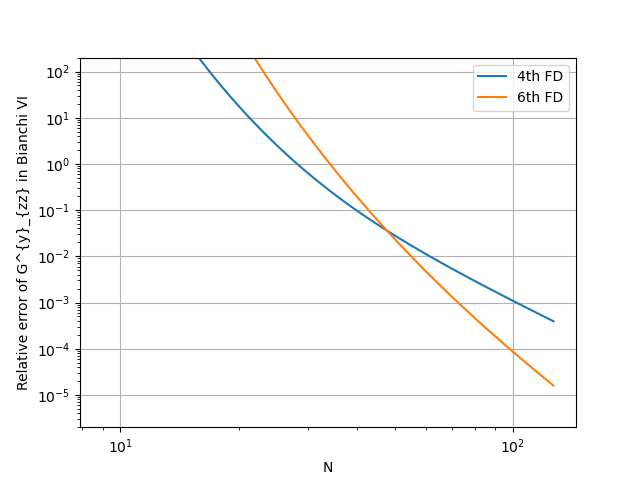

(2e-06, 200.0)

In [47]:
plt.figure()
plt.loglog(np.arange(9, 128, 1), Err, label='4th FD')
plt.loglog(np.arange(9, 128, 1), Err6, label='6th FD')
plt.grid()
plt.legend()
plt.xlabel('N')
plt.ylabel('Relative error of G^{y}_{zz} in Bianchi VI')
plt.ylim(2e-6, 2e2)

<IPython.core.display.Javascript object>


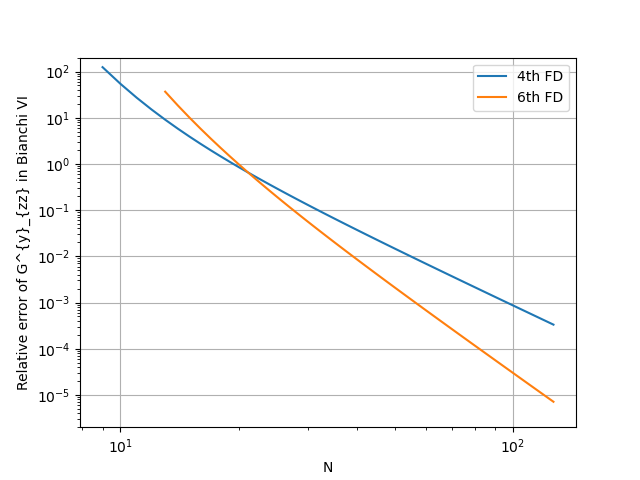

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


(2e-06, 200.0)

In [50]:
plt.figure()
plt.loglog(np.arange(9, 128, 1), Err, label='4th FD')
plt.loglog(np.arange(9, 128, 1), Err6, label='6th FD')
plt.grid()
plt.legend()
plt.xlabel('N')
plt.ylabel('Relative error of G^{y}_{zz} in Bianchi VI')
plt.ylim(2e-6, 2e2)

In [42]:
Err = []
for N in range(9, 128):
    L = 20
    dx = L/N
    FD = FD_file.FD_Class(dx, periodic_boundary=False)#, order6=True)
    xyz = np.arange(-L/2, L/2, dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    
    D = np.exp(-2*x)
    v = FD.D3x(D)
    vth = -2*D
    ic = 2*FD.mask
    Err += [np.mean(np.ma.masked_invalid(abs(v[ic:-ic,ic:-ic,ic:-ic]/vth[ic:-ic,ic:-ic,ic:-ic]-1)))]
    #print('{}, {:.2e}'.format(N, Err[-1]))

In [8]:
print(np.sum(abs(Gudd[0,0,2])))
print(np.sum(abs(Gudd[0,1,2])))
print(np.sum(abs(Gudd[1,0,2])))
print(np.sum(abs(Gudd[1,1,2])))
print(np.sum(abs(Gudd[2,0,0])))
print(np.sum(abs(Gudd[2,0,1])))
print(np.sum(abs(Gudd[2,0,1])))
print(np.sum(abs(Gudd[2,1,1])))
print(np.sum(abs(Gudd[2,1,2])))
print(np.sum(abs(Gudd[2,2,2])))

3.1370895532219e-12
7.448648921157214e-10
7.163618321363564e-09
6.441813637680804e-12
0.00021307251106860573
0.32114056470742597
0.32114056470742597
9722.399565744436
4.4706074093258105e-12
4.47060740932581e-12


<IPython.core.display.Javascript object>


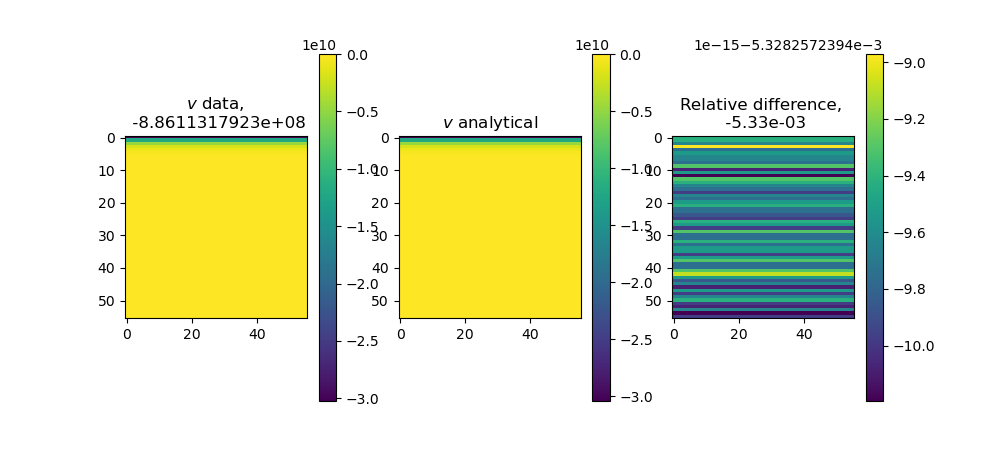

Text(0.5, 1.0, 'Relative difference, \n -5.33e-03')

In [9]:
#v = Gudd[0,0,0]
#vth = -m*m*Box_ones

#v = Gudd[0,0,1]
#vth = -m*(t**(-1-q+s))*np.exp(x)/k

#v = Gudd[0,1,1]
#vth = -(t**(-2-2*q+2*s))*np.exp(2*x)/(k*k)

#v = Gudd[0,2,2]
#vth = (t**(-2+2*q+2*s))*np.exp(-2*x)/(k*k)

#v = Gudd[1,0,0]
#vth = k*m*(1+m*m)*(t**(1+q-s))*np.exp(-x)

#v = Gudd[1,0,1]
#vth = (1+m*m)*Box_ones

#v = Gudd[1,1,1]
#vth = np.exp(x)*m*(t**(-1-q+s))/k

v = Gudd[1,2,2]
vth = -np.exp(-3*x)*m*(t**(-1+3*q+s))/k

#v = Gudd[2,0,2]
#vth = -Box_ones


i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(v[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$v$ data, '+'\n {:.10e}'.format(np.mean(v[4:-4,4:-4,i])))
plt.subplot(132)
plt.imshow(vth[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$v$ analytical')
plt.subplot(133)
plt.imshow(v[4:-4,4:-4,i]/vth[4:-4,4:-4,i]-1)
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.mean(v[4:-4,4:-4,i]/vth[4:-4,4:-4,i]-1)))

<IPython.core.display.Javascript object>


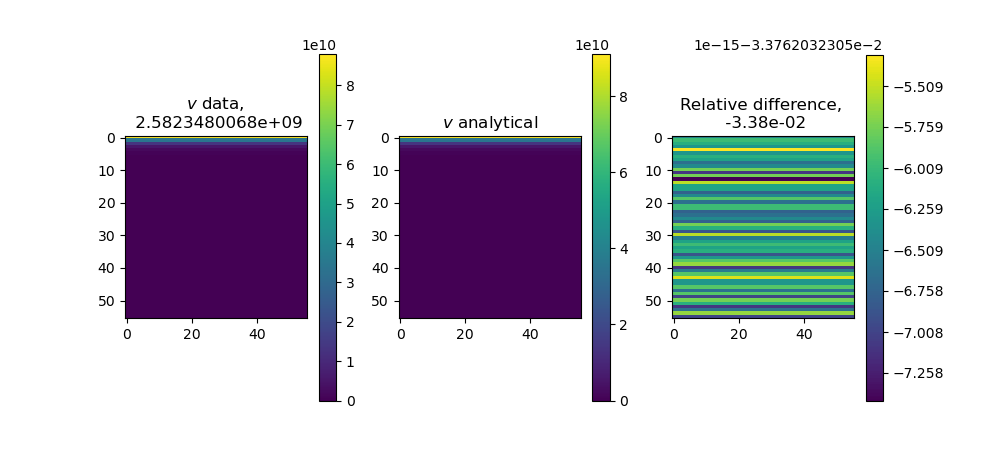

Text(0.5, 1.0, 'Relative difference, \n -3.38e-02')

In [40]:
i = 7
v = FD.D3x(Gudd[1,2,2])
#vth = -np.exp(-3*x)*m*(t**(-1+3*q+s))/k
vth = 3*np.exp(-3*x)*m*(t**(-1+3*q+s))/k

plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(v[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$v$ data, '+'\n {:.10e}'.format(np.mean(v[4:-4,4:-4,i])))
plt.subplot(132)
plt.imshow(vth[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$v$ analytical')
plt.subplot(133)
plt.imshow(v[4:-4,4:-4,i]/vth[4:-4,4:-4,i]-1)
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.mean(v[4:-4,4:-4,i]/vth[4:-4,4:-4,i]-1)))

## Check Ricci

In [8]:
RicciS3th = -2/(k*k*t*t)
ER128 = RicciS3 - RicciS3th
ERr128 = RicciS3 / RicciS3th - 1

In [33]:
convergence_order_3d(ER16, ER32)
convergence_order_3d(ER32, ER64)
convergence_order_3d(ER64, ER128)

Convergence order:  3.892225774784169
Convergence order:  4.061195649293039
Convergence order:  4.164441961604073


<IPython.core.display.Javascript object>


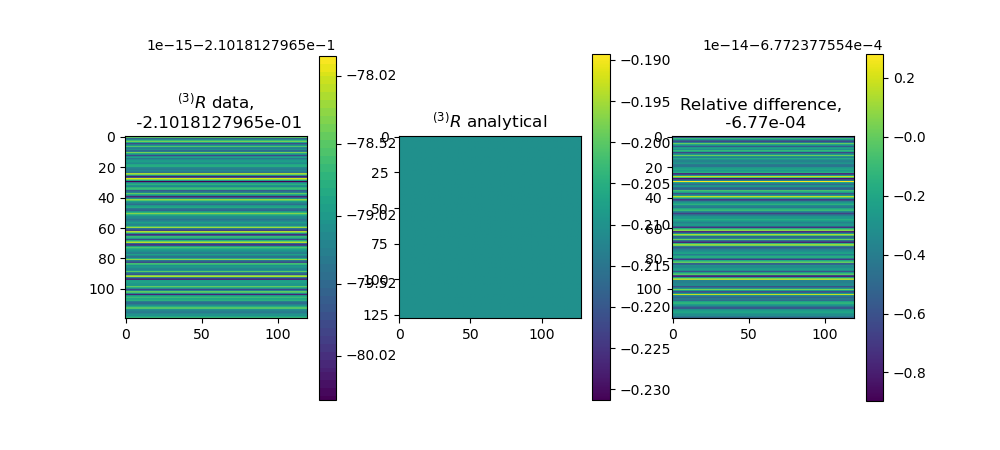

Text(0.5, 1.0, 'Relative difference, \n -6.77e-04')

In [9]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(RicciS3[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'${}^{(3)}R$ data, '+'\n {:.10e}'.format(np.mean(RicciS3[4:-4,4:-4,i])))
plt.subplot(132)
plt.imshow(RicciS3th*Box_ones[:,:,i])
plt.colorbar()
plt.title(r'${}^{(3)}R$ analytical')
plt.subplot(133)
plt.imshow(RicciS3[4:-4,4:-4,i]/RicciS3th-1)
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.mean(RicciS3[4:-4,4:-4,i]/RicciS3th-1)))

## Check $B^2$ and $B^T$

In [10]:
Bdown, B2, Btrace = RCW.Weyl_B(LCdown, gdown, gup, Gudd, Kdown, kappa, Tdown4)

B2th = (9*m*m*(1+q-s)*(1+q-s)+16*(1-s)*(1-s))*abs(gdetth)/(8*(k**4)*(t**(6+4*s)))

EB2128 = B2 - B2th
EB2r128 = B2 / B2th - 1
EBT128 = Btrace

In [36]:
convergence_order_3d(EB216, EB232)
convergence_order_3d(EB232, EB264)
convergence_order_3d(EB264, EB2128)
print('--')
convergence_order_3d(EBT16, EBT32)
convergence_order_3d(EBT32, EBT64)
convergence_order_3d(EBT64, EBT128)

Convergence order:  3.4904073039014554
Convergence order:  3.871206102468184
Convergence order:  4.003613862671751
--
Convergence order:  --
Convergence order:  --
Convergence order:  --


<ipython-input-2-d34230f664c5>:3: RuntimeWarning: invalid value encountered in true_divide
  c = abs(E1)/abs(E2)


<IPython.core.display.Javascript object>


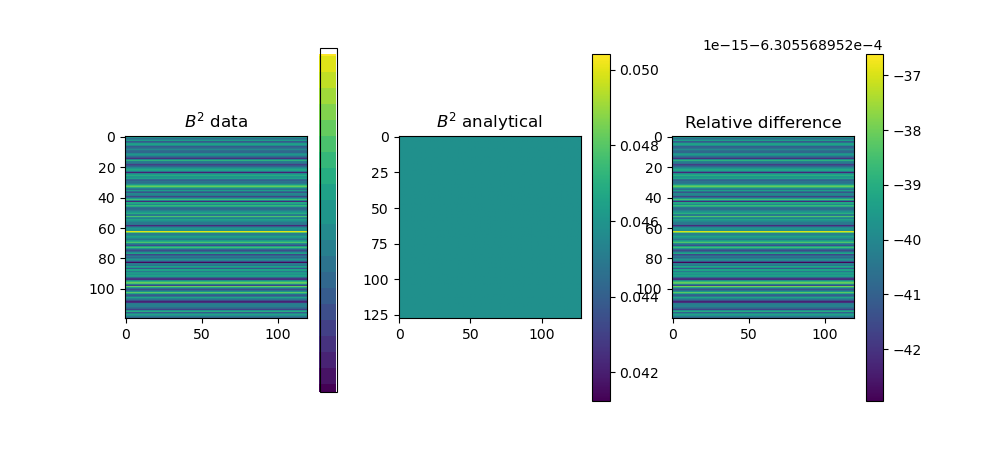

<IPython.core.display.Javascript object>


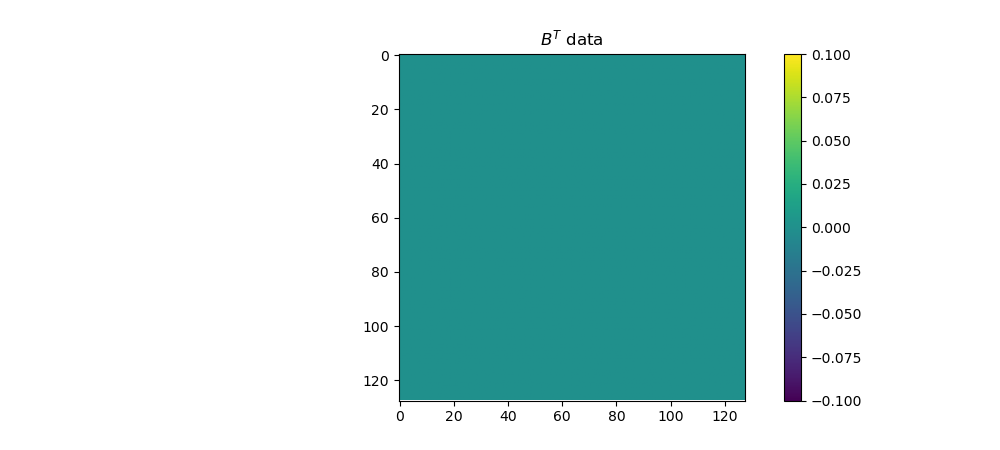

Text(0.5, 1.0, '$B^T$ data')

In [11]:
i = 7
cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(B2[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$B^2$ data')
plt.subplot(132)
plt.imshow(B2th[:,:,1])
plt.colorbar()
plt.title(r'$B^2$ analytical')
plt.subplot(133)
diff = B2/B2th-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
plt.imshow(Btrace[:,:,i])
plt.colorbar()
plt.title(r'$B^T$ data')

## Check $E^2$ and $E^T$

In [12]:
Kmixed = np.einsum('ij...,jk...->ik...', gup, Kdown)
K = np.einsum('ab...,ab...->...', gup, Kdown)
Edown, Eup, E2, Etrace = RCW.Weyl_E(gdown, gup, RicciS3, RicciTdown, Kdown, kappa, rho, 0.0, Tdown4[1:,1:])
c1 = (1 + q - s)
c2 = (-1 + s)
E2th = Box_ones*(16 + 16*k*k*(-2*q*q + m*m*c1*c1) + (k**4)*(16*q*q*(q*q + 3*c2*c2) + m*m*(11*q*q - 18*q*c2 + 3*c2*c2)*c1*c1 + 4*(m**4)*(c1**4)))/(24*((k*t)**4))

EE2128 = E2 - E2th
EE2r128 = E2 / E2th - 1
EET128 = Etrace

In [39]:
convergence_order_3d(EE216, EE232)
convergence_order_3d(EE232, EE264)
convergence_order_3d(EE264, EE2128)
print('--')
convergence_order_3d(EET16, EET32)
convergence_order_3d(EET32, EET64)
convergence_order_3d(EET64, EET128)

Convergence order:  6.314407953669184
Convergence order:  3.5709410136112063
Convergence order:  3.877570056024228
--
Convergence order:  0.5367452827940051
Convergence order:  0.31218422945432844
Convergence order:  0.05147952226475919


<IPython.core.display.Javascript object>


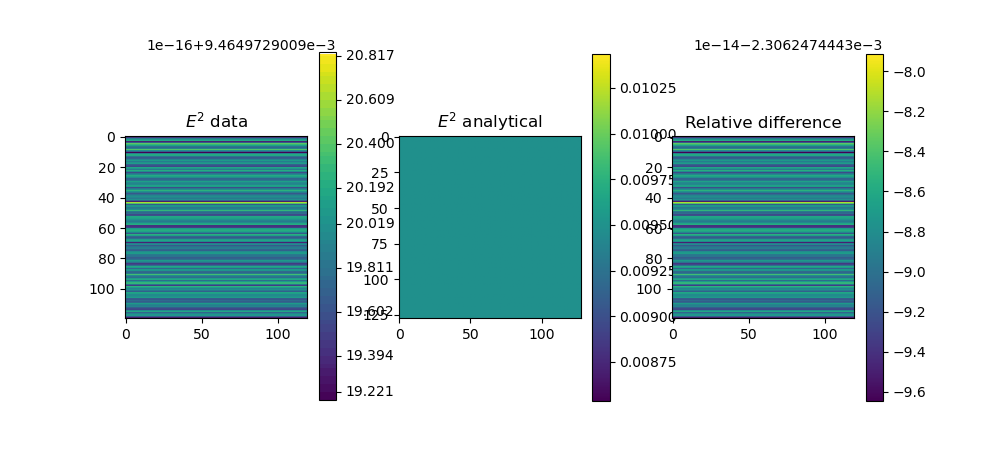

<IPython.core.display.Javascript object>


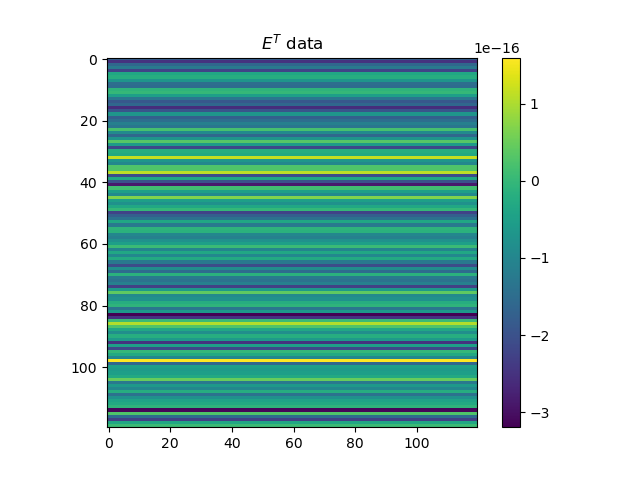

Text(0.5, 1.0, '$E^T$ data')

In [13]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(E2[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$E^2$ data')
plt.subplot(132)
plt.imshow(E2th[:,:,i])
plt.colorbar()
plt.title(r'$E^2$ analytical')
plt.subplot(133)
plt.imshow(E2[4:-4,4:-4,i]/E2th[4:-4,4:-4,i]-1)
plt.colorbar()
plt.title('Relative difference')

plt.figure()
plt.imshow(Etrace[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$E^T$ data')

<IPython.core.display.Javascript object>


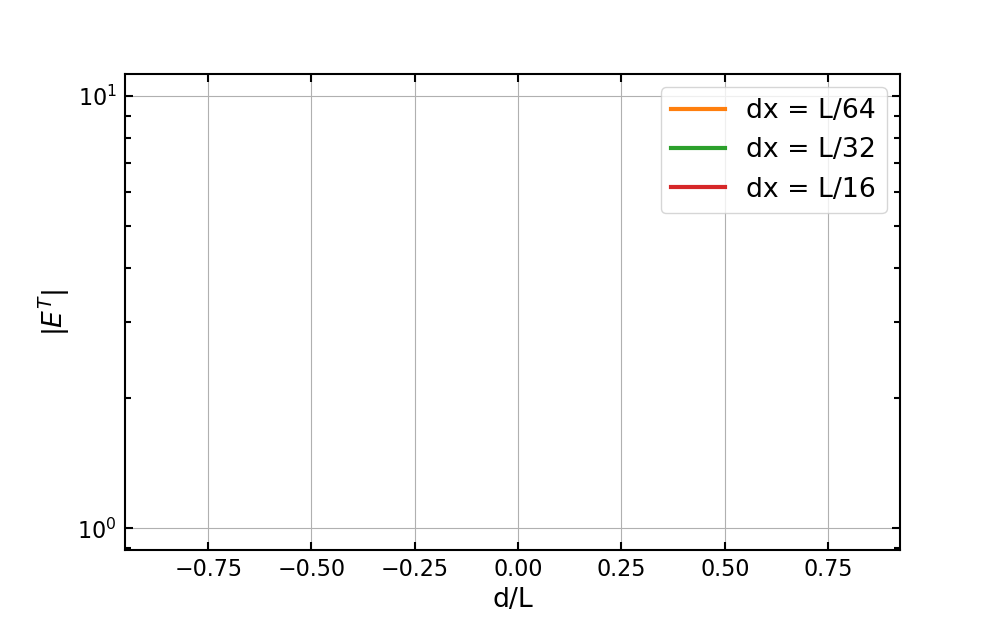

In [124]:
def diag(f):
    ffinal = []
    for i in range(len(f)):
        ffinal += [abs(f[i,i,i])]
    return np.array(ffinal)

x = np.arange(-1*np.sqrt(3)/2, 1*np.sqrt(3)/2, 1*np.sqrt(3)/128)
phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
#plt.semilogy(x, diag(ESET128), label='dx = L/128')
plt.semilogy(x[0::2], diag(ESBT64), color='C1', label='dx = L/64')
plt.semilogy(x[0::4], diag(ESBT32), color='C2', label='dx = L/32')
plt.semilogy(x[0::8], diag(ESBT16), color='C3', label='dx = L/16')
plt.ylabel(r'$|E^{T}|$')
plt.xlabel('d/L')
plt.legend()
plt.grid()
#plt.savefig('/home/robynm/simulations/BianchiVI_N128/Plots/ET_Geo.pdf')

# Geometrical

In [97]:
dt = dx*0.05
tIN = 1.5-4*dt
tF = 1.5+dt

In [98]:
for it, t in enumerate(np.arange(tIN, tF, dt)):
    gdown = np.array([[k*k*t*t*(1+m*m)*Box_ones,   m*k*(t**(1+s-q))*np.exp(x), Box_zero],
                      [m*k*(t**(1+s-q))*np.exp(x), (t**(2*(s-q)))*np.exp(2*x), Box_zero],
                      [Box_zero,                   Box_zero,                   (t**(2*(s+q)))*np.exp(-2*x)]])
    Kdown = (-1/2)*np.array([[2*k*k*t*(1+m*m)*Box_ones,         (1+s-q)*m*k*(t**(s-q))*np.exp(x),       Box_zero],
                             [(1+s-q)*m*k*(t**(s-q))*np.exp(x), (2*(s-q))*(t**(2*(s-q)-1))*np.exp(2*x), Box_zero],
                             [Box_zero,                         Box_zero,                               (2*(s+q))*(t**(2*(s+q)-1))*np.exp(-2*x)]])
    fname = '/home/robynm/simulations/BianchiVI_N'+str(N)+'/all_iterations/BianchiVI_it_{:06d}.hdf5'.format(it)
    with h5py.File(fname, 'w') as fnew:
        fnew['gxx it={}'.format(it)] = gdown[0,0]
        fnew['gxy it={}'.format(it)] = gdown[0,1]
        fnew['gxz it={}'.format(it)] = gdown[0,2]
        fnew['gyy it={}'.format(it)] = gdown[1,1]
        fnew['gyz it={}'.format(it)] = gdown[1,2]
        fnew['gzz it={}'.format(it)] = gdown[2,2]
        fnew['kxx it={}'.format(it)] = Kdown[0,0]
        fnew['kxy it={}'.format(it)] = Kdown[0,1]
        fnew['kxz it={}'.format(it)] = Kdown[0,2]
        fnew['kyy it={}'.format(it)] = Kdown[1,1]
        fnew['kyz it={}'.format(it)] = Kdown[1,2]
        fnew['kzz it={}'.format(it)] = Kdown[2,2]

In [86]:
t = 1.5
gdetth = k*k*(t**(2+4*s))*Box_ones
it = np.argmin(abs(np.arange(tIN, tF, dt)-t))
fname = '/home/robynm/simulations/BianchiVI_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
f = h5py.File(fname, 'r')
f.keys()

<KeysViewHDF5 ['B2', 'Btrace', 'E2', 'Etrace', 'RicciS4', 'dtdtgdown4', 'dtdxgdown4', 'dtdygdown4', 'dtdzgdown4', 'dtgdown4', 'dxgdown4', 'dygdown4', 'dzgdown4']>

## Check Ricci

In [87]:
RicciS4 = np.array(f['RicciS4'])
RicciS4th = Box_ones*(-4+k*k*(m*m*(1+q-s)*(1+q-s)+4*(q*q+3*s*s)))/(2*k*k*t*t)
ESR128 = RicciS4 - RicciS4th
ESRr128 = RicciS4 / RicciS4th - 1

In [30]:
convergence_order_3d(ER32, ER64)

Convergence order:  4.15845559817672


<IPython.core.display.Javascript object>


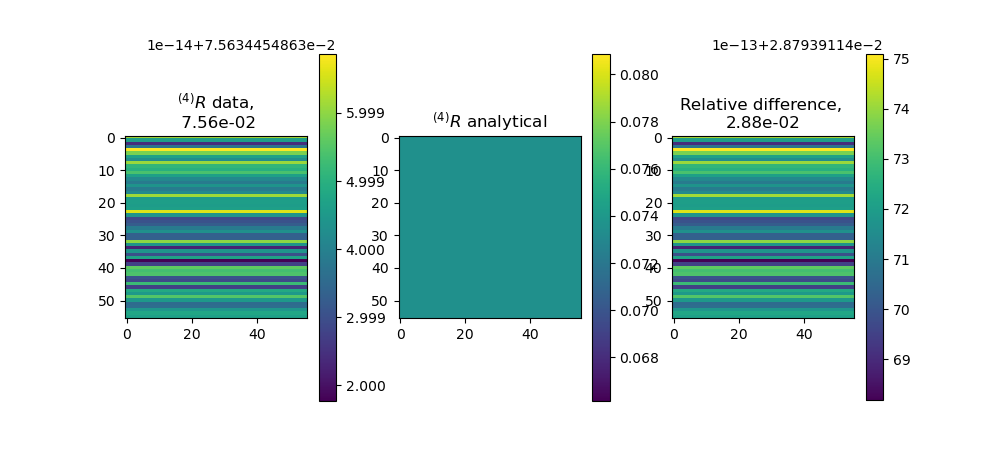

Text(0.5, 1.0, 'Relative difference, \n2.88e-02')

In [11]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(RicciS4[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'${}^{(4)}R$ data, '+'\n {:.2e}'.format(np.mean(RicciS4[4:-4,4:-4,i])))
plt.subplot(132)
plt.imshow(RicciS4th[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'${}^{(4)}R$ analytical')
plt.subplot(133)
plt.imshow(RicciS4[4:-4,4:-4,i]/RicciS4th[4:-4,4:-4,i]-1)
plt.colorbar()
plt.title('Relative difference, \n'+'{:.2e}'.format(np.mean(RicciS4[4:-4,4:-4,i]/RicciS4th[4:-4,4:-4,i]-1)))

## Check contracted Einstein equation

In [12]:
gdown = np.array([[k*k*t*t*(1+m*m)*Box_ones, m*k*(t**(1+s-q))*np.exp(x), Box_zero],
                  [m*k*(t**(1+s-q))*np.exp(x), (t**(2*(s-q)))*np.exp(2*x), Box_zero],
                  [Box_zero, Box_zero, (t**(2*(s+q)))*np.exp(-2*x)]])
gdown4 = np.array([[-Box_ones, Box_zero,   Box_zero,   Box_zero],
                   [Box_zero,  gdown[0,0], gdown[0,1], gdown[0,2]],
                   [Box_zero,  gdown[1,0], gdown[1,1], gdown[1,2]],
                   [Box_zero,  gdown[2,0], gdown[2,1], gdown[2,2]]])
glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
gdet = RRead.det(glist)
gup = RRead.inv(glist, gdet)
gup4 = np.array([[-Box_ones, Box_zero,   Box_zero,   Box_zero],
                 [Box_zero,  gup[0,0], gup[0,1], gup[0,2]],
                 [Box_zero,  gup[1,0], gup[1,1], gup[1,2]],
                 [Box_zero,  gup[2,0], gup[2,1], gup[2,2]]])

G        = 1
kappa    = 8*np.pi*G
rho      = 2*(-sign*(5*gamma-6)*np.sqrt((9*gamma-1)*(gamma-1))-15*(gamma-2)*(gamma-1))/(kappa*gamma*gamma*(35*gamma-36)*t*t)
pressure = (gamma-1)*rho
u4 = np.sqrt(-2*q/(gamma*kappa*rho*k*k*t*t*(q-3*s+1)))
u1 = k*(q-3*s+1)*u4
u2 = m*(1+q-s)*u1/(4*q)
u3 = 0
uup = np.array([u4*Box_ones, u1*Box_ones, u2*Box_ones, u3*Box_ones])
udown = np.einsum('ab...,b...->a...', gdown4, uup)
Tdown4 = gdown4#(rho+pressure)*np.einsum('a...,b...->ab...',udown,udown)+pressure*gdown4
Ttrace = np.einsum('ab...,ab...->...',gup4, Tdown4) #this is faux

<IPython.core.display.Javascript object>


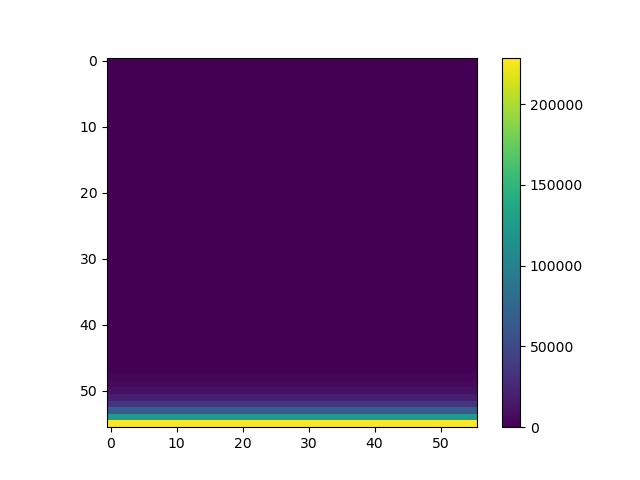

In [20]:
cut = 4
i = 10
v = np.einsum('ab...,b...,a...->...', gdown4, uup, uup)
plt.figure()
plt.imshow(v[cut:-cut,cut:-cut,i])
plt.colorbar()

<IPython.core.display.Javascript object>


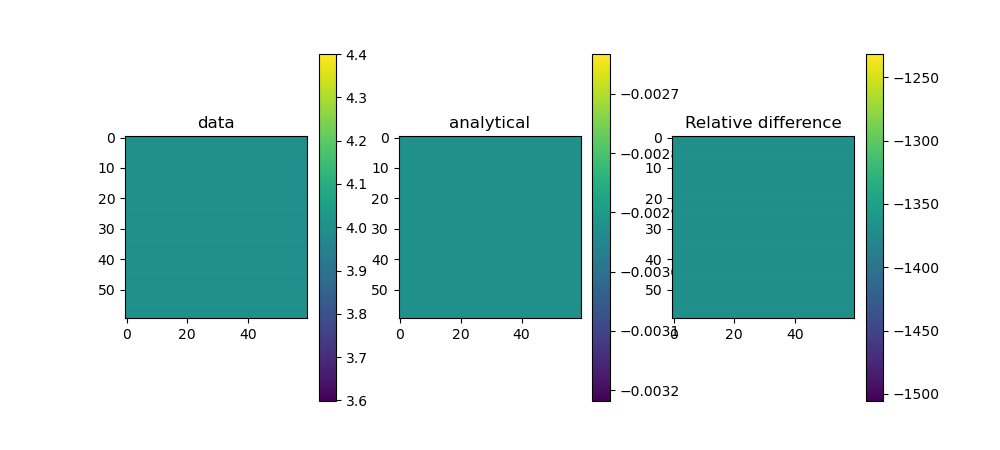

Text(0.5, 1.0, 'Relative difference')

In [15]:
cut = 2
i = 8
v = Ttrace
vth = rho*(-4+3*gamma)*Box_ones
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(v[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title('data')
plt.subplot(132)
plt.imshow(vth[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title('analytical')
plt.subplot(133)
diff = v/vth-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

## Check $B^2$ and $B^T$

In [88]:
B2 = np.array(f['B2'])
B2th = (9*m*m*(1+q-s)*(1+q-s)+16*(1-s)*(1-s))*abs(gdetth)/(8*(k**4)*(t**(6+4*s)))
Btrace = np.array(f['Btrace'])
ESB2128 = B2 - B2th
ESB2r128 = B2 / B2th - 1
ESBT128 = Btrace

In [33]:
np.mean(EB232), np.mean(EB264)

(-0.0066178159410176015, -0.00029023819152771053)

In [34]:
convergence_order_3d(EB232, EB264)
convergence_order_3d(EBT32, EBT64)

Convergence order:  3.9880767736050036
Convergence order:  --


<ipython-input-2-d34230f664c5>:3: RuntimeWarning: invalid value encountered in true_divide
  c = abs(E1)/abs(E2)


<IPython.core.display.Javascript object>


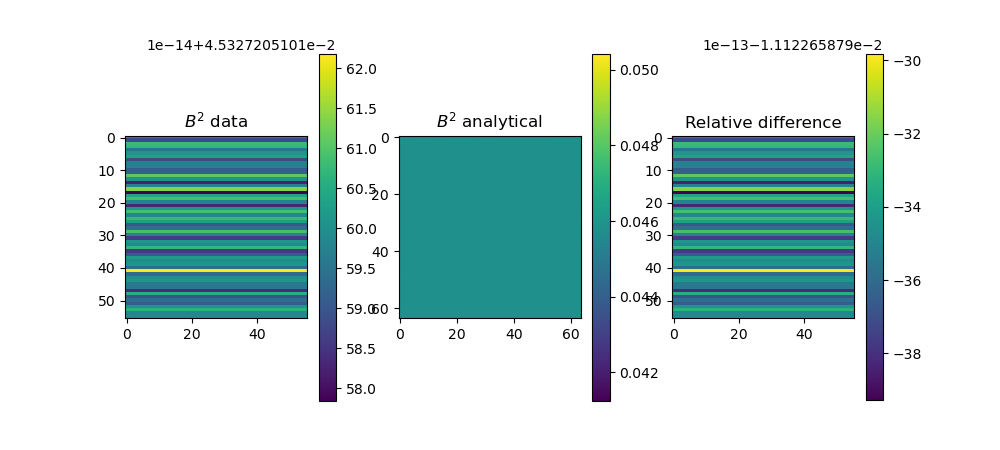

<IPython.core.display.Javascript object>


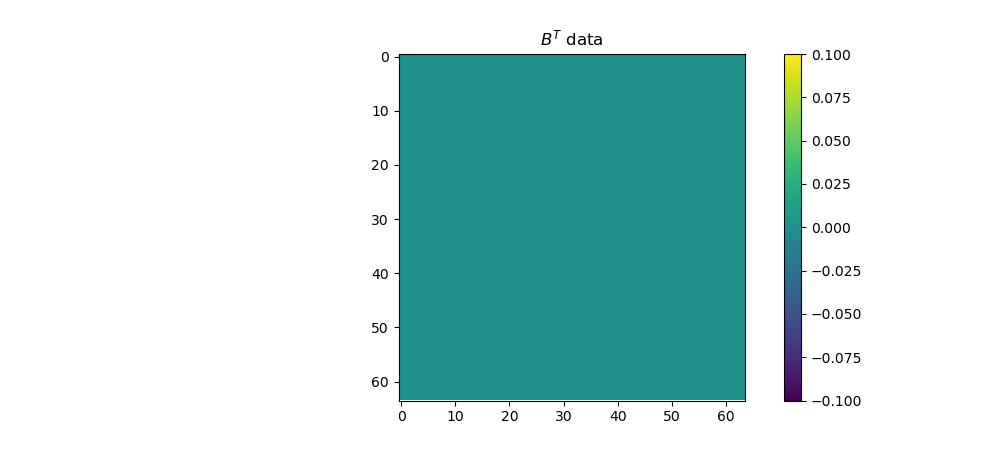

Text(0.5, 1.0, '$B^T$ data')

In [8]:
i = 7
cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(B2[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$B^2$ data')
plt.subplot(132)
plt.imshow(B2th[:,:,1])
plt.colorbar()
plt.title(r'$B^2$ analytical')
plt.subplot(133)
diff = B2/B2th-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
plt.imshow(Btrace[:,:,i])
plt.colorbar()
plt.title(r'$B^T$ data')

## Check $E^2$ and $E^T$

In [89]:
E2 = np.array(f['E2'])
c1 = (1 + q - s)
c2 = (-1 + s)
E2th = Box_ones*(16 + 16*k*k*(-2*q*q + m*m*c1*c1) + (k**4)*(16*q*q*(q*q + 3*c2*c2) + m*m*(11*q*q - 18*q*c2 + 3*c2*c2)*c1*c1 + 4*(m**4)*(c1**4)))/(24*((k*t)**4))
Etrace = np.array(f['Etrace'])

ESE2128 = E2 - E2th
ESE2r128 = E2 / E2th - 1
ESET128 = Etrace

<IPython.core.display.Javascript object>


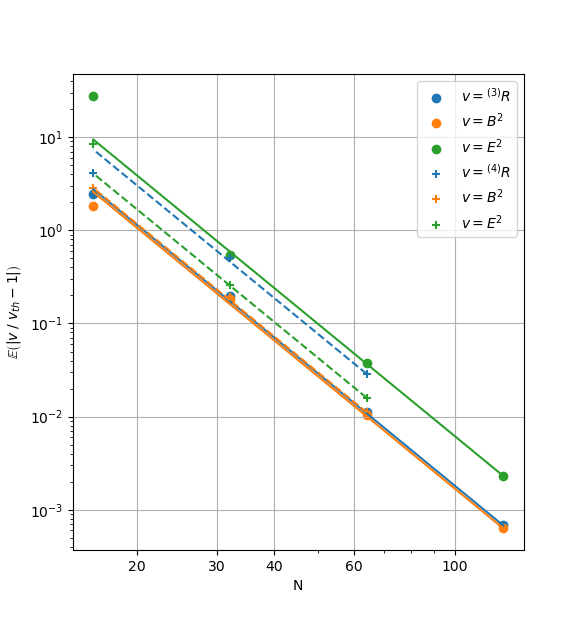

In [115]:
phi = (1+np.sqrt(5))/2
fsize = 10/phi
plt.figure(figsize=(fsize/phi+2,fsize))

yplot =[np.mean(abs(ERr128[4:-4,4:-4,4:-4])), np.mean(abs(ERr64[4:-4,4:-4,4:-4])), np.mean(abs(ERr32[4:-4,4:-4,4:-4])), np.mean(abs(ERr16[4:-4,4:-4,4:-4]))]
xplot = [128,64,32,16]
plt.scatter(xplot, yplot, label=r'$v={}^{(3)}R$')
plt.loglog(xplot, [yplot[0], yplot[0]*16, yplot[0]*(16*16), yplot[0]*(16*16*16)])

yplot =[np.mean(abs(EB2r128[4:-4,4:-4,4:-4])), np.mean(abs(EB2r64[4:-4,4:-4,4:-4])), np.mean(abs(EB2r32[4:-4,4:-4,4:-4])), np.mean(abs(EB2r16[4:-4,4:-4,4:-4]))]
xplot = [128,64,32,16]
plt.scatter(xplot, yplot, label=r'$v=B^2$')
plt.loglog(xplot, [yplot[0], yplot[0]*16, yplot[0]*(16*16), yplot[0]*(16*16*16)])

yplot =[np.mean(abs(EE2r128[4:-4,4:-4,4:-4])), np.mean(abs(EE2r64[4:-4,4:-4,4:-4])), np.mean(abs(EE2r32[4:-4,4:-4,4:-4])), np.mean(abs(EE2r16[4:-4,4:-4,4:-4]))]
xplot = [128,64,32,16]
plt.scatter(xplot, yplot, label=r'$v=E^2$')
plt.loglog(xplot, [yplot[0], yplot[0]*16, yplot[0]*(16*16), yplot[0]*(16*16*16)])

yplot =[np.mean(abs(ESRr64[4:-4,4:-4,4:-4])), np.mean(abs(ESRr32[4:-4,4:-4,4:-4])), np.mean(abs(ESRr16[4:-4,4:-4,4:-4]))]
xplot = [64,32,16]
plt.scatter(xplot, yplot, color='C0', marker='+', label=r'$v={}^{(4)}R$')
plt.loglog(xplot, [yplot[0], yplot[0]*16, yplot[0]*16*16], color='C0', linestyle='--')

yplot =[np.mean(abs(ESB2r64[4:-4,4:-4,4:-4])), np.mean(abs(ESB2r32[4:-4,4:-4,4:-4])), np.mean(abs(ESB2r16[4:-4,4:-4,4:-4]))]
xplot = [64,32,16]
plt.scatter(xplot, yplot, color='C1', marker='+', label=r'$v=B^2$')
plt.loglog(xplot, [yplot[0], yplot[0]*16, yplot[0]*16*16], color='C1', linestyle='--')

yplot =[np.mean(abs(ESE2r64[4:-4,4:-4,4:-4])), np.mean(abs(ESE2r32[4:-4,4:-4,4:-4])), np.mean(abs(ESE2r16[4:-4,4:-4,4:-4]))]
xplot = [64,32,16]
plt.scatter(xplot, yplot, color='C2', marker='+', label=r'$v=E^2$')
plt.loglog(xplot, [yplot[0], yplot[0]*16, yplot[0]*16*16], color='C2', linestyle='--')

plt.ylabel(r'$\mathbb{E}\left(|v \;/\; v_{th}-1|\right)$')
plt.xlabel('N')
plt.legend()
plt.grid()
plt.xticks(ticks=[20,30,40,60,100],labels=['20','30','40','60','100'])
#plt.savefig('/home/robynm/simulations/BianchiVI_N128/Plots/Convergence.pdf')

In [37]:
convergence_order_3d(EE232, EE264)
convergence_order_3d(EET32, EET64)

Convergence order:  3.675969508999853
Convergence order:  0.008618907844465076


<ipython-input-2-d34230f664c5>:3: RuntimeWarning: divide by zero encountered in true_divide
  c = abs(E1)/abs(E2)
<ipython-input-2-d34230f664c5>:4: RuntimeWarning: divide by zero encountered in log
  print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))


<IPython.core.display.Javascript object>


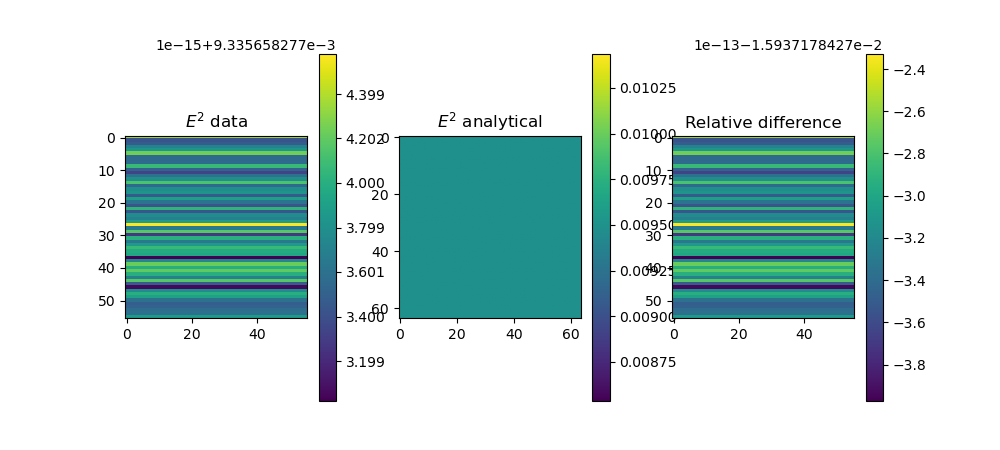

<IPython.core.display.Javascript object>


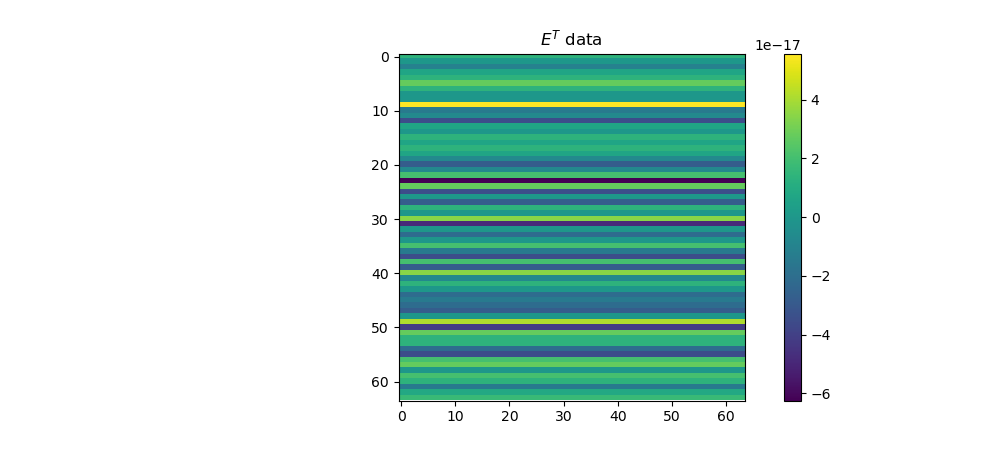

Text(0.5, 1.0, '$E^T$ data')

In [10]:
i = 7
cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(E2[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$E^2$ data')
plt.subplot(132)
plt.imshow(E2th[:,:,i])
plt.colorbar()
plt.title(r'$E^2$ analytical')
plt.subplot(133)
plt.imshow(E2[cut:-cut,cut:-cut,i]/E2th[cut:-cut,cut:-cut,i]-1)
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
plt.imshow(Etrace[:,:,i])
plt.colorbar()
plt.title(r'$E^T$ data')

# Invariants

In [6]:
t = 1.5

A = k*k*t*t*(1+m*m)*Box_ones
B = m*k*(t**(1+s-q))*np.exp(x)
C = (t**(2*(s-q)))*np.exp(2*x)
D = (t**(2*(s+q)))*np.exp(-2*x)

gdown = np.array([[A, B, Box_zero],
                  [B, C, Box_zero],
                  [Box_zero, Box_zero, D]])

Kdown = (-1/2)*np.array([[2*k*k*t*(1+m*m)*Box_ones, (1+s-q)*m*k*(t**(s-q))*np.exp(x), Box_zero],
                         [(1+s-q)*m*k*(t**(s-q))*np.exp(x), (2*(s-q))*(t**(2*(s-q)-1))*np.exp(2*x), Box_zero],
                         [Box_zero, Box_zero, (2*(s+q))*(t**(2*(s+q)-1))*np.exp(-2*x)]])
glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
gdet = RRead.det3(glist)
gdetth = k*k*(t**(2+4*s))*Box_ones
gup = RRead.inv3(glist)
gmixed = np.einsum('ij...,jk...->ik...', gup, gdown)

RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
Gudd = RCW.Christoffel_symbol(gdown, gup)
RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)

G        = 1
kappa    = 8*np.pi*G
gdown4 = np.array([[-Box_ones, Box_zero,   Box_zero,   Box_zero],
                   [Box_zero,  gdown[0,0], gdown[0,1], gdown[0,2]],
                   [Box_zero,  gdown[1,0], gdown[1,1], gdown[1,2]],
                   [Box_zero,  gdown[2,0], gdown[2,1], gdown[2,2]]])

uup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
udown = np.array([-Box_ones, Box_zero, Box_zero, Box_zero])
u_axu_b = np.einsum('a...,b...->ab...', udown, udown)
hdown = gdown4 + u_axu_b
rho = -(4 + k*k*(4*q*q + m*m*((1 + q - s)**2) - 4*s*(2 + s)))/(4*k*k*kappa*t*t)
p = (4 - k*k*(12*q*q + 3*m*m*((1 + q - s)**2) + 4*s*(-2 + 5*s)))/(12*k*k*kappa*t*t)
qx = Box_ones*(-4*q+m*m*(-1-q+s))/(2*kappa*t)
qy = -(np.exp(x)*m*(1+q-s)*(t**(-2-q+s)))/(2*k*kappa)
qdown = np.array([Box_zero, qx, qy, Box_zero])
pixx = Box_ones*(-8 - 3*k*k*m*m*m*m*((1 + q - s)**2) - 8*k*k*(-1 + s)*s + m*m*(4 - k*k*(3 + 3*q*q - 6*q*(-1 + s) - 14*s + 11*s*s)))/(6*kappa)
pixy = -(np.exp(x)*m*(-4 + k*k*(3 + 6*q + 3*q*q + 3*m*m*((1 + q - s)**2) - 8*s + 5*s*s))*(t**(-1 - q + s)))/(6*k*kappa)
piyy = np.exp(2*x)*(4 - k*k*(3*m*m*((1 + q - s)**2) + 4*(1 + 3*q - s)*s))*(t**(-2 - 2*q + 2*s))/(6*k*k*kappa)
pizz = np.exp(-2*x)*(2 + 2*k*k*s*(-1 + 3*q + s))*(t**(2*(-1 + q + s)))/(3*k*k*kappa)
pidown = np.array([[Box_zero, Box_zero, Box_zero, Box_zero],
                   [Box_zero, pixx, pixy, Box_zero],
                   [Box_zero, pixy, piyy, Box_zero],
                   [Box_zero, Box_zero, Box_zero, pizz]])

Tdown4 = rho*u_axu_b+p*hdown+np.einsum('a...,b...->ab...', qdown, udown)+np.einsum('b...,a...->ab...', qdown, udown)+pidown

LCdown = np.zeros([3,3,3, N, N, N])
LCdown[0, 1, 2, :, :, :] = np.sqrt(abs(gdet))
LCdown[1, 2, 0, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 0, 1, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 1, 0, :, :, :] = -np.sqrt(abs(gdet))
LCdown[0, 2, 1, :, :, :] = -np.sqrt(abs(gdet))
LCdown[1, 0, 2, :, :, :] = -np.sqrt(abs(gdet))

nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
LCuud3 = np.einsum('ae...,bf...,efc...->abc...', gup, gup, LCdown)
Bdict = RCW.Weyl_B(gdown, gup, nup, LCuud3, Gudd, Kdown)
Edict = RCW.Weyl_E(gdown, gup, LCuud3, Gudd, RicciS3, RicciTdown, Kdown, kappa, Tdown4[1:,1:])
invar_dict = RCW.Weyl_Invar(gdown, Edict, Bdict)

In [7]:
icut = 6

In [8]:
print('psi0 = ', np.average(abs(invar_dict['psi0'][icut:-icut, icut:-icut, icut:-icut])))
print('psi1 = ', np.average(abs(invar_dict['psi1'][icut:-icut, icut:-icut, icut:-icut])))
print('psi2 = ', np.average(abs(invar_dict['psi2'][icut:-icut, icut:-icut, icut:-icut])))
print('psi3 = ', np.average(abs(invar_dict['psi3'][icut:-icut, icut:-icut, icut:-icut])))
print('psi4 = ', np.average(abs(invar_dict['psi4'][icut:-icut, icut:-icut, icut:-icut])))

psi0 =  0.14703447119873903
psi1 =  0.031018310511142188
psi2 =  0.02787807580957583
psi3 =  0.018099663487647532
psi4 =  0.15477508941278886


In [9]:
print('S-1 = ', np.average(abs(invar_dict['S'][icut:-icut, icut:-icut, icut:-icut])-1)) # ill defined as I=J=0
I = np.array(invar_dict['I'])
J = np.array(invar_dict['J'])
Scrit = I*I*I-27*J*J
print('Scrit = ', np.average(abs(Scrit[icut:-icut, icut:-icut, icut:-icut])))
print('I = ', np.average(abs(invar_dict['I'][icut:-icut, icut:-icut, icut:-icut])))
print('J = ', np.average(abs(invar_dict['J'][icut:-icut, icut:-icut, icut:-icut])))
print('K = ', np.average(abs(invar_dict['K'][icut:-icut, icut:-icut, icut:-icut])))
print('LS = ', np.average(abs(invar_dict['LS'][icut:-icut, icut:-icut, icut:-icut])))
print('N = ', np.average(abs(invar_dict['N'][icut:-icut, icut:-icut, icut:-icut])))
print('|E| = ', np.average(abs(invar_dict['|E|'][icut:-icut, icut:-icut, icut:-icut])))
print('|B| = ', np.average(abs(invar_dict['|B|'][icut:-icut, icut:-icut, icut:-icut])))

S-1 =  1.791206166854762
Scrit =  2.278038482179492e-05
I =  0.01818002815044544
J =  0.0007881445975044655
K =  0.0003221491789873464
LS =  0.0039872338577175235
N =  0.0006262849489304649
|E| =  0.09756142675117835
|B| =  0.21419217607236832


<IPython.core.display.Javascript object>


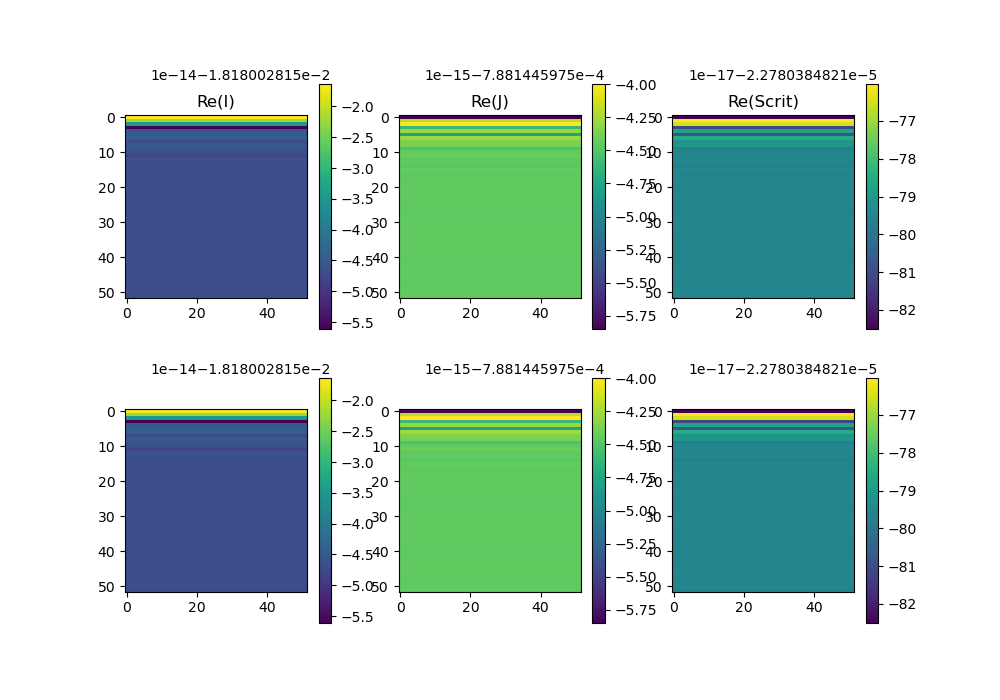

<IPython.core.display.Javascript object>


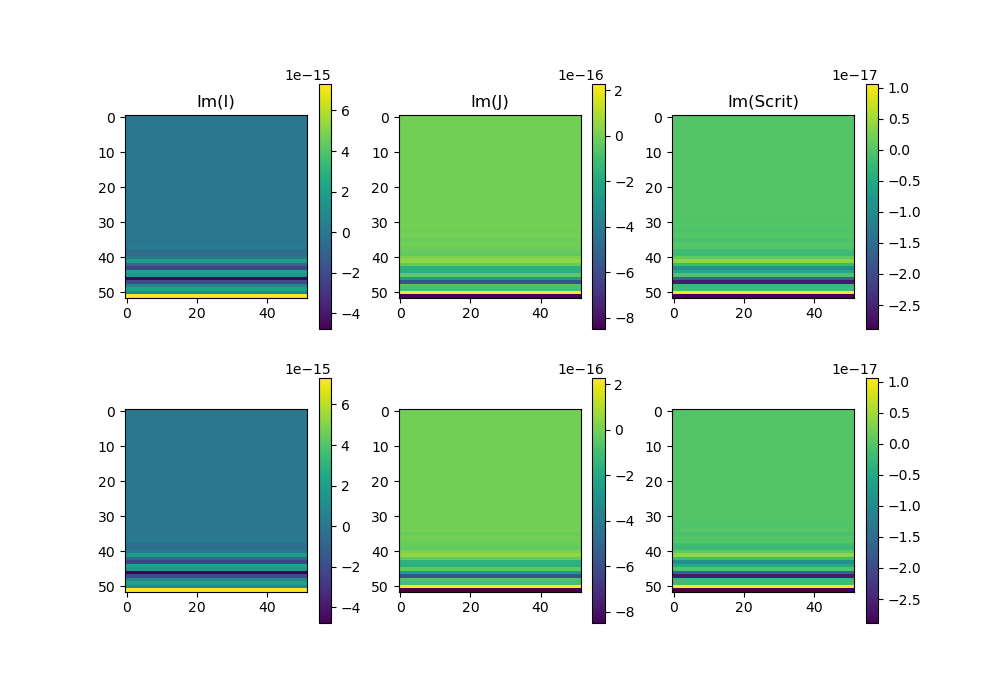

In [10]:
i = 32
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.real(invar_dict['I'][icut:-icut,i,icut:-icut]))
plt.title('Re(I)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.real(invar_dict['I'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.real(invar_dict['J'][icut:-icut,i,icut:-icut]))
plt.title('Re(J)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.real(invar_dict['J'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.real(Scrit[icut:-icut,i,icut:-icut]))
plt.title('Re(Scrit)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.real(Scrit[icut:-icut,icut:-icut,i]))
plt.colorbar()


plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.imag(invar_dict['I'][icut:-icut,i,icut:-icut]))
plt.title('Im(I)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.imag(invar_dict['I'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.imag(invar_dict['J'][icut:-icut,i,icut:-icut]))
plt.title('Im(J)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.imag(invar_dict['J'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.imag(Scrit[icut:-icut,i,icut:-icut]))
plt.title('Im(Scrit)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.imag(Scrit[icut:-icut,icut:-icut,i]))
plt.colorbar()

<IPython.core.display.Javascript object>


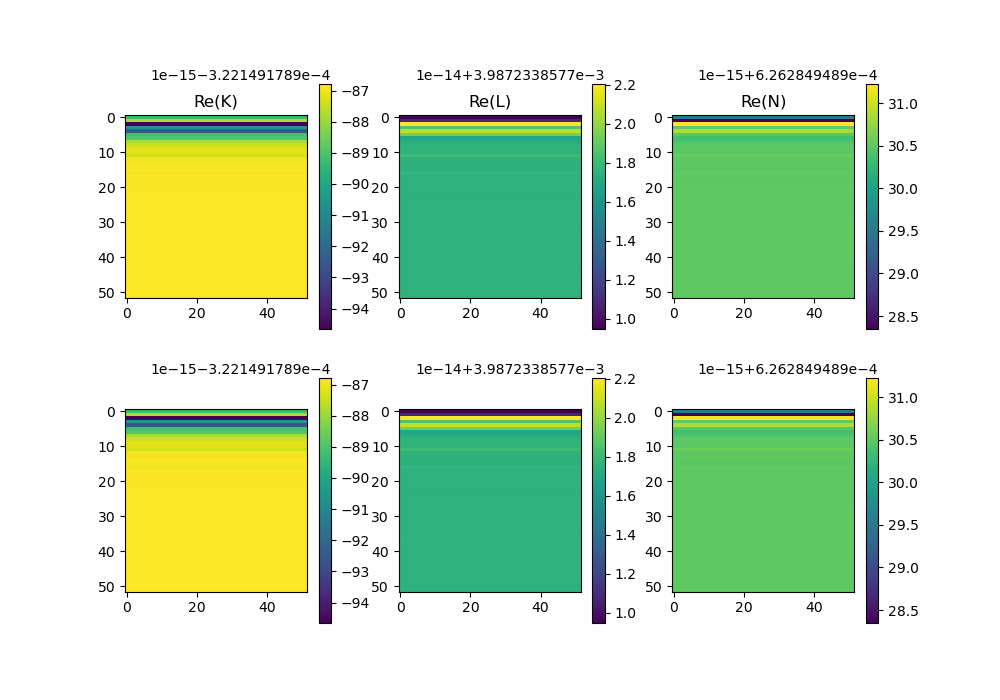

<IPython.core.display.Javascript object>


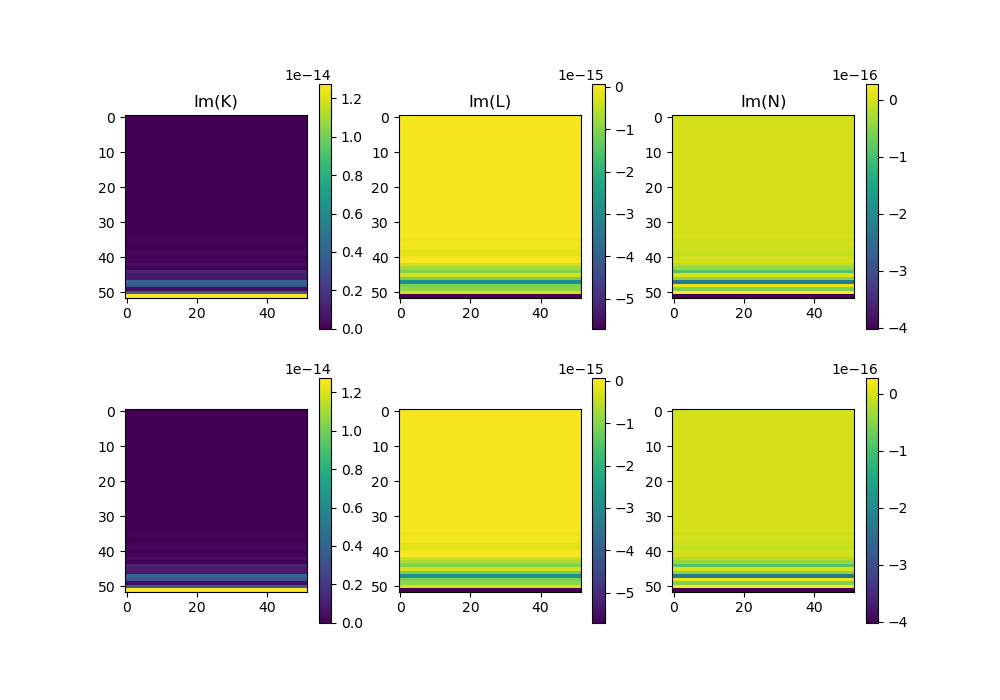

In [11]:
i = 32
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.real(invar_dict['K'][icut:-icut,i,icut:-icut]))
plt.title('Re(K)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.real(invar_dict['K'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.real(invar_dict['LS'][icut:-icut,i,icut:-icut]))
plt.title('Re(L)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.real(invar_dict['LS'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.real(invar_dict['N'][icut:-icut,i,icut:-icut]))
plt.title('Re(N)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.real(invar_dict['N'][icut:-icut,icut:-icut,i]))
plt.colorbar()


plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.imag(invar_dict['K'][icut:-icut,i,icut:-icut]))
plt.title('Im(K)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.imag(invar_dict['K'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.imag(invar_dict['LS'][icut:-icut,i,icut:-icut]))
plt.title('Im(L)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.imag(invar_dict['LS'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.imag(invar_dict['N'][icut:-icut,i,icut:-icut]))
plt.title('Im(N)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.imag(invar_dict['N'][icut:-icut,icut:-icut,i]))
plt.colorbar()

# type I